In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [85]:
import collections
from pathlib import Path
import json
import pprint
import os
import pdb

import cv2
import numpy as np
import pandas as pd
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt

You can use the python debugger `pdb` to step through code.

- `pdb.set_trace()` to set a breakpoint
- `%debug` magic to trace an error

Commands you need to know:
- h (help)
- s (step into)
- n (next line / step over — you can also hit enter)
- c (continue to the next breakpoint)
- u (up the call stack)
- d (down the call stack)
- p (print) — force print when there is a single letter variable that’s also a command.
- l (list) — show the line above and below it
- q (quit) — very important

## Import datasets

- Dataset is annotated by using [sloth](https://sloth.readthedocs.io/en/latest/)
- Annotation format: 
    - **Origin**: Top left conner of image
    - **x,y**: Top-left conner of bounding box.
    - **height**: Height of the bounding box.
    - **width**: Width of the bounding box.

In [3]:
PATH = Path('/home/tenzin/d2/data/')
list(PATH.iterdir())

[PosixPath('/home/tenzin/d2/data/myconfig.pyc'),
 PosixPath('/home/tenzin/d2/data/.Rhistory'),
 PosixPath('/home/tenzin/d2/data/myconfig.py'),
 PosixPath('/home/tenzin/d2/data/tmp'),
 PosixPath('/home/tenzin/d2/data/labels.json'),
 PosixPath('/home/tenzin/d2/data/dataset-01'),
 PosixPath('/home/tenzin/d2/data/tub_17_18-08-03'),
 PosixPath('/home/tenzin/d2/data/tub_5_18-08-03'),
 PosixPath('/home/tenzin/d2/data/dataset-02')]

In [4]:
trn_j = json.load((PATH/'labels.json').open())  # list of images with annotation
pprint.pprint(trn_j[0])

{'annotations': [{'class': 'orange',
                  'height': 35.79507484025583,
                  'type': 'rect',
                  'width': 21.945789931823516,
                  'x': 0.6391977650045684,
                  'y': 8.30957094505939},
                 {'class': 'orange',
                  'height': 21.093526245150763,
                  'type': 'rect',
                  'width': 15.979944125114201,
                  'x': 57.74086477207935,
                  'y': 11.292493848414042},
                 {'class': 'green',
                  'height': 28.55083350353739,
                  'type': 'rect',
                  'width': 22.37192177515989,
                  'x': 24.50258099184179,
                  'y': 8.735702788395768},
                 {'class': 'green',
                  'height': 17.684471498459725,
                  'type': 'rect',
                  'width': 12.570889378423189,
                  'x': 83.52184129393027,
                  'y': 12.1447575350868},
 

In [5]:
trn_j[0].keys()

dict_keys(['class', 'annotations', 'filename'])

In [6]:
CLASS, FILENAME, ANNOTATION = 'class', 'filename', 'annotations'
trn_j[0][ANNOTATION][:2]

[{'class': 'orange',
  'height': 35.79507484025583,
  'type': 'rect',
  'width': 21.945789931823516,
  'x': 0.6391977650045684,
  'y': 8.30957094505939},
 {'class': 'orange',
  'height': 21.093526245150763,
  'type': 'rect',
  'width': 15.979944125114201,
  'x': 57.74086477207935,
  'y': 11.292493848414042}]

### Preprocessing the dataset
- Creating hash table to mapping id to name or filename

In [8]:
cats = {i: name for i, name in enumerate(['orange', 'green', 'bg'])}
trn_fns = {int(dp[FILENAME].split('/')[-1].split('_')[0]):dp[FILENAME] for dp in trn_j}
trn_ids = list(trn_fns.keys())
trn_fns[1], cats

('dataset-02/1_cam-image_array_.jpg', {0: 'orange', 1: 'green', 2: 'bg'})

In [9]:
#JPGS = 'dataset-02'  # images dir name

In [10]:
IMG_PATH = PATH
list(IMG_PATH.iterdir())[:5]

[PosixPath('/home/tenzin/d2/data/myconfig.pyc'),
 PosixPath('/home/tenzin/d2/data/.Rhistory'),
 PosixPath('/home/tenzin/d2/data/myconfig.py'),
 PosixPath('/home/tenzin/d2/data/tmp'),
 PosixPath('/home/tenzin/d2/data/labels.json')]

- We convert height/width into bottom-right and our x/y are consistent with numpy, which is top-left
- New annotation:
    - **x1,y1**: Top-left (which is same x, y)
    - **x2, y2**: Bottom left (x + width, y + height)

In [13]:
def hw_bb(bb): return np.array([bb[1], bb[0], bb[1]+bb[3]-1, bb[0]+bb[2]-1])

trn_anno = collections.defaultdict(lambda: [])
for dp in trn_j:
    dp_name = dp[FILENAME].split('/')[-1]
    dp_id = int(dp_name.split('_')[0])
    for ann in dp[ANNOTATION]:
        if ann:
            bb = [ann['x'], ann['y'], ann['width'], ann['height']]
            bb = hw_bb(bb)
            cls = 0 if ann[CLASS] == "orange" else 1
        else:
            bb = [0, 0, 0, 0]   # for bg
            cls = 2
        trn_anno[dp_id].append((bb, cls))
len(trn_anno)

442

In [14]:
im_a = trn_anno[1]; im_a  #x1, y1, x2, y2

[(array([ 8.30957095,  0.63919777, 43.10464579, 21.5849877 ]), 0),
 (array([11.29249385, 57.74086477, 31.38602009, 72.7208089 ]), 0),
 (array([ 8.73570279, 24.50258099, 36.28653629, 45.87450277]), 1),
 (array([12.14475754, 83.52184129, 28.82922903, 95.09273067]), 1),
 (array([ 18.32366926, 150.4245407 ,  44.80917316, 159.43863902]), 0)]

In [15]:
trn_fns[1]

'dataset-02/1_cam-image_array_.jpg'

In [16]:
trn_j[0][FILENAME]

'dataset-02/1_cam-image_array_.jpg'

In [17]:
trn_j[0]

{'annotations': [{'class': 'orange',
   'height': 35.79507484025583,
   'type': 'rect',
   'width': 21.945789931823516,
   'x': 0.6391977650045684,
   'y': 8.30957094505939},
  {'class': 'orange',
   'height': 21.093526245150763,
   'type': 'rect',
   'width': 15.979944125114201,
   'x': 57.74086477207935,
   'y': 11.292493848414042},
  {'class': 'green',
   'height': 28.55083350353739,
   'type': 'rect',
   'width': 22.37192177515989,
   'x': 24.50258099184179,
   'y': 8.735702788395768},
  {'class': 'green',
   'height': 17.684471498459725,
   'type': 'rect',
   'width': 12.570889378423189,
   'x': 83.52184129393027,
   'y': 12.1447575350868},
  {'class': 'orange',
   'height': 27.48550389519644,
   'type': 'rect',
   'width': 10.014098318404905,
   'x': 150.42454069774178,
   'y': 18.323669263464293}],
 'class': 'image',
 'filename': 'dataset-02/1_cam-image_array_.jpg'}

In [18]:
cats[trn_anno[1][0][1]], cats[trn_anno[1][2][1]]

('orange', 'green')

In [19]:
# to covert back to heght/width
def bb_hw(bb): return np.array([bb[1], bb[0], bb[3]-bb[1]+1, bb[2]-bb[0]+1])

# sanity check
bb_sloth = [0.6391977650045684, 8.30957094505939, 21.945789931823516, 35.79507484025583]
bb_cr = hw_bb(bb_sloth)

print('expected: {} \n  actual: {}'.format(bb_sloth, bb_hw(bb_cr)))

expected: [0.6391977650045684, 8.30957094505939, 21.945789931823516, 35.79507484025583] 
  actual: [ 0.63919777  8.30957095 21.94578993 35.79507484]


In [20]:
## Using fastai open_image
def open_image(fn):
    """ Opens an image using OpenCV given the file path
    
    Arguments:
        fn: the file path of image
    Returns:
        The image in RBG format as numpy array floats normalization to range[0.0, 1.0]
    """
    
    flags = flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    if not os.path.exists(str(fn)):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(str(fn)):
        raise OSError('Is a directory: {}'.format(fn))
    else:
        #res = np.array(Image.open(fn), dtype=np.float32)/255
        #if len(res.shape)==2: res = np.repeat(res[...,None],3,2)
        #return res
        try:
            im = cv2.imread(str(fn), flags).astype(np.float32)/255
            if im is None: raise OSError('File not recognized by opencv: {}'.format(fn))
            return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

In [21]:
im = open_image(IMG_PATH/trn_fns[1])

In [22]:
im.shape

(120, 160, 3)

- Matplotlib's **plt.subplots** is a really useful wrapper for creating plots, regardless of whether you have more than one subplot.
- Note that Matplotlib has an optional object-oriented API which I think is much easier to understand and use (although few examples online use it!)

In [23]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

- trick to making text visible regardless of background is to use white text with black outline, or visa versa.
- Here's how to do it in matplotlib.

In [24]:
def draw_outline(o, lw):
    ''' Drawing outline
    Arguments:
        o: matplotlib plotting object, like ax, plt
        lw: line width
    '''
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

- Note that * in argument lists is the splat operator. In this case it's a little shortcut compared to writing out b[-2],b[-1].

In [25]:
def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    #draw_outline(patch, 4)

In [26]:
def draw_text(ax, xy, txt, sz=14, color='black'):
    text = ax.text(*xy, txt,
                   verticalalignment='top', color=color, fontsize=sz)
    #draw_outline(text, 1)

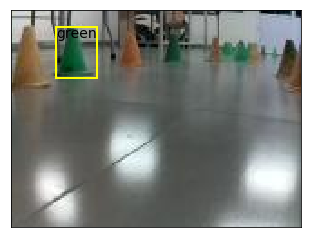

In [27]:
ax = show_img(im)
b = bb_hw(trn_anno[1][2][0])
draw_rect(ax, b, color='yellow')
draw_text(ax, b[:2], cats[trn_anno[1][2][1]])

- Showing all the labels

In [28]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(12,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b, color='yellow')
        draw_text(ax, b[:2], cats[c], sz=16)

In [29]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

(120, 160, 3)


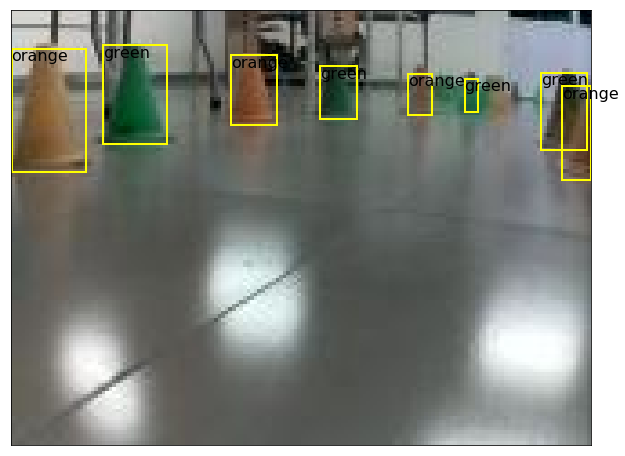

In [30]:
draw_idx(4)

## Largest Cone

In [31]:
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:] - x[0][:2]), reverse=True)
    return b[0]

In [32]:
trn_lrg_anno = {a: get_lrg(b) for a, b in trn_anno.items()}

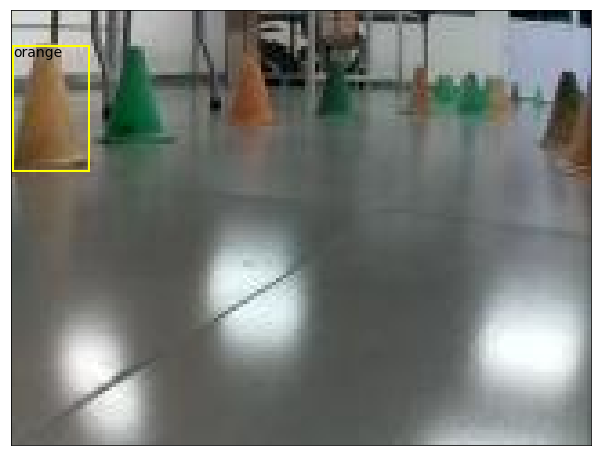

In [33]:
ax = show_img(im, figsize=(12, 8))
b = bb_hw(trn_lrg_anno[22][0])
draw_rect(ax, b, color='yellow')
draw_text(ax, b[:2], cats[trn_lrg_anno[22][1]])

- saving filename and bounding box to csv file
- csv only accept str, int, float

In [34]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/lrg.csv'

In [35]:
df = pd.DataFrame({'filename': [trn_fns[i] for i in trn_ids], 
                   'labels': [trn_anno[i] for i in trn_ids]}, columns=['filename', 'lables'])
df.to_csv(CSV, index=False)

In [36]:
CSV.open().readlines()[:5]

['filename,lables\n',
 'dataset-02/1_cam-image_array_.jpg,\n',
 'dataset-02/2_cam-image_array_.jpg,\n',
 'dataset-02/3_cam-image_array_.jpg,\n',
 'dataset-01/4_cam-image_array_.jpg,\n']

In [37]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 3
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

id2cat = list(cats.values())
id2cat

['orange', 'green', 'bg']

In [92]:
# Showing ground truth
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = '{}: '.format(i)
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += ' {:.2f}'.format(pr)
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

In [47]:
x = [open_image(IMG_PATH/fn) for fn in trn_fns.values()]

In [48]:
y = [[[]]*len(trn_anno), [[[]]]*len(trn_anno)]
for i, annos in enumerate(trn_anno.values()):
    y[0][i] = [None]*len(annos)
    y[1][i] = [None]*len(annos)
    for j, anno in enumerate(annos):
        y[0][i][j] = anno[0]
        y[1][i][j] = anno[1]

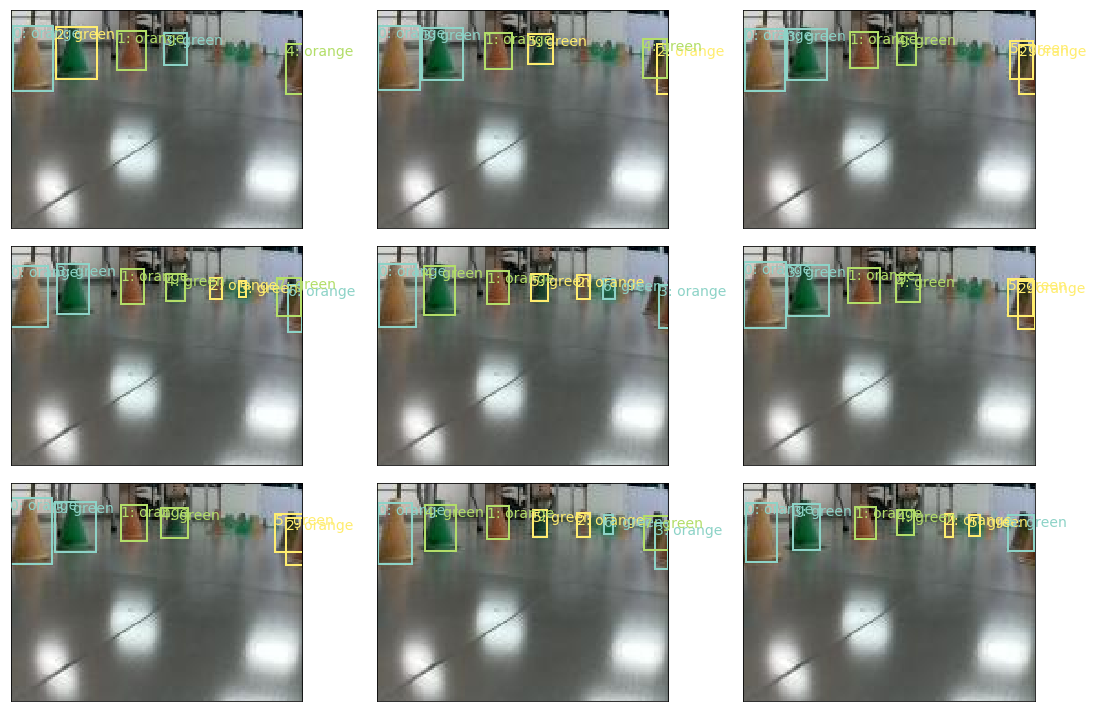

In [122]:
fig, axes = plt.subplots(3, 3, figsize=(16, 10))
for i, ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

## Anchor Box

[0.125 0.125 0.125 0.125 0.375 0.375 0.375 0.375 0.625 0.625 0.625 0.625
 0.875 0.875 0.875 0.875]
[0.125 0.375 0.625 0.875 0.125 0.375 0.625 0.875 0.125 0.375 0.625 0.875
 0.125 0.375 0.625 0.875]


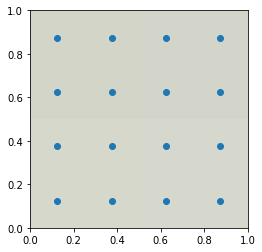

In [115]:
anc_grid = 4
k = 1

anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
print(anc_x)
print(anc_y)
anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anchors = np.concatenate([anc_ctrs, anc_sizes], axis=1)

grid_sizes = np.array([1/anc_grid])
plt.scatter(anc_x, anc_y)
plt.imshow(im)
plt.xlim(0, 1)
plt.ylim(0, 1);

In [111]:
anchors

array([[0.125, 0.125, 0.25 , 0.25 ],
       [0.125, 0.375, 0.25 , 0.25 ],
       [0.125, 0.625, 0.25 , 0.25 ],
       [0.125, 0.875, 0.25 , 0.25 ],
       [0.375, 0.125, 0.25 , 0.25 ],
       [0.375, 0.375, 0.25 , 0.25 ],
       [0.375, 0.625, 0.25 , 0.25 ],
       [0.375, 0.875, 0.25 , 0.25 ],
       [0.625, 0.125, 0.25 , 0.25 ],
       [0.625, 0.375, 0.25 , 0.25 ],
       [0.625, 0.625, 0.25 , 0.25 ],
       [0.625, 0.875, 0.25 , 0.25 ],
       [0.875, 0.125, 0.25 , 0.25 ],
       [0.875, 0.375, 0.25 , 0.25 ],
       [0.875, 0.625, 0.25 , 0.25 ],
       [0.875, 0.875, 0.25 , 0.25 ]])

In [99]:
def hw2corners(ctr, hw): return np.concatenate([ctr-hw/2, ctr+hw/2], axis=1)

anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])
anchor_cnr

array([[0.  , 0.  , 0.25, 0.25],
       [0.  , 0.25, 0.25, 0.5 ],
       [0.  , 0.5 , 0.25, 0.75],
       [0.  , 0.75, 0.25, 1.  ],
       [0.25, 0.  , 0.5 , 0.25],
       [0.25, 0.25, 0.5 , 0.5 ],
       [0.25, 0.5 , 0.5 , 0.75],
       [0.25, 0.75, 0.5 , 1.  ],
       [0.5 , 0.  , 0.75, 0.25],
       [0.5 , 0.25, 0.75, 0.5 ],
       [0.5 , 0.5 , 0.75, 0.75],
       [0.5 , 0.75, 0.75, 1.  ],
       [0.75, 0.  , 1.  , 0.25],
       [0.75, 0.25, 1.  , 0.5 ],
       [0.75, 0.5 , 1.  , 0.75],
       [0.75, 0.75, 1.  , 1.  ]])

In [100]:
def gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, (bbox*224),
         clas, prs if prs is not None else None, thresh)

In [101]:
idx=7
ima = x[idx]
bbox = y[0][idx]
clas = y[1][idx]

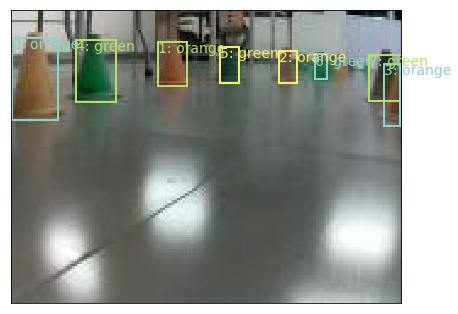

In [102]:
fig, ax = plt.subplots(figsize=(7,7))
gt(ax, ima, bbox, clas)

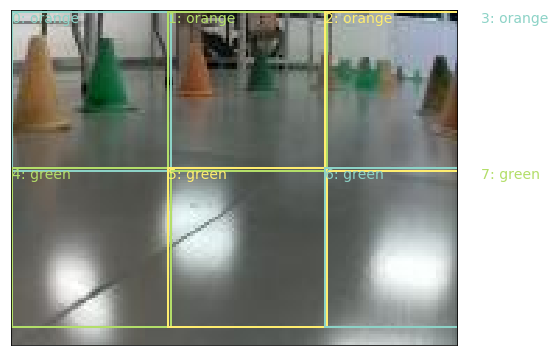

In [121]:
fig, ax = plt.subplots(figsize=(8,8))
gt(ax, ima, anchor_cnr, clas)

In [44]:
## IOU or Ja

In [45]:
def intersect(box_a, box_b):
    max_xy = np.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = np.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union